In [64]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/clustering/src')

!pip install pymysql
import prepare

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as scs

from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler

X_train, X_test, X_val, y_train, y_test, y_val = prepare.wrangle_zillow(test_size=.10, k=3, thresh=.4)
X_train['county'] = X_train.fips.map({6111:"Ventura", 6037:"Los Angeles", 6059:"Orange"})


These columns were dropped.
                          missing count  missing %
airconditioningtypeid             49095   0.680722
architecturalstyletypeid          71916   0.997144
basementsqft                      72072   0.999307
buildingclasstypeid               72122   1.000000
decktypeid                        71508   0.991487
finishedfloor1squarefeet          66101   0.916516
finishedsquarefeet13              72081   0.999432
finishedsquarefeet15              72111   0.999847
finishedsquarefeet50              66101   0.916516
finishedsquarefeet6               71955   0.997684
fireplacecnt                      63861   0.885458
garagecarcnt                      46826   0.649261
garagetotalsqft                   46826   0.649261
hashottuborspa                    70585   0.978689
poolcnt                           56399   0.781994
poolsizesum                       71255   0.987979
pooltypeid10                      71659   0.993580
pooltypeid2                       71048   0.985109
po



Your target variable is logerror.

1. Is target significantly different for properties in LAC vs OC vs VC?
2. Divide age of house into bins; same question for age bins.
3. What are the top five features for predicting target?
4. Is there a linear relationship between price per square foot and target? (Pearson r)
5.  Compute the mean(logerror) by zipcode and the overall mean(logerror). Run a t-test between the overall mean and the mean for each zip code. What zip codes have an error significantly higher or lower than the expected error?

Answer those questions through a mix of statistical tests and visualizations.

While doing this, a new idea occurred to me. Wouldn't it be better to ONLY keep logerror outliers defined as 2*IQR above Q3 or below Q1? By identifying the worst errors, we stand the best chance o improving the final model. Another way to frame it: if the absolute logerror is less than the mean, the prediction is above average. Let's call it good and not explore it.


In [65]:
X_train.head()

,bathroomcnt,bedroomcnt,buildingqualitytypeid,finishedsqft,fips,heatingorsystemtypeid,latitude,longitude,propertylandusetypeid,regionidcity,regionidzip,structuretaxvalue,taxvalue,landtaxvalue,taxamount,censustractandblock,95982.0,95983.0,95984.0,95985.0,95986.0,95987.0,95988.0,95989.0,95991.0,95992.0,95993.0,95994.0,95995.0,95996.0,95997.0,95998.0,95999.0,96000.0,96001.0,96002.0,96003.0,96004.0,96005.0,96006.0,...,97088.0,97089.0,97091.0,97092.0,97094.0,97097.0,97098.0,97099.0,97101.0,97104.0,97106.0,97107.0,97108.0,97109.0,97111.0,97113.0,97116.0,97118.0,97119.0,97298.0,97316.0,97317.0,97318.0,97319.0,97323.0,97324.0,97328.0,97329.0,97330.0,97331.0,97344.0,399675.0,livingarearatio,buildinglandvalueratio,taxrate,age,acres,sqftvalue,age_bins,county
parcelid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
14727305,2.0,2.0,5.0,917.0,6059.0,2.0,33.667018,-117.808401,266.0,52650.0,96948.0,59222.0,372791.0,313569.0,3856.36,6.059053e+13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.195046,0.188864,0.010345,37.0,0.158127,406.533261,0,Orange
11190250,2.0,3.0,8.0,1501.0,6037.0,2.0,34.597538,-118.164197,261.0,40227.0,97329.0,115562.0,144445.0,28883.0,3229.97,6.037910e+13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.170375,4.001039,0.022361,24.0,0.202250,96.232512,0,Los Angeles
12239022,1.0,2.0,5.0,728.0,6037.0,7.0,33.930823,-118.270469,261.0,12447.0,96042.0,58683.0,97795.0,39112.0,3590.55,6.037241e+13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.374101,1.500384,0.036715,71.0,0.044674,134.333791,1,Los Angeles
12706913,2.0,4.0,8.0,1816.0,6037.0,2.0,33.783600,-118.369011,261.0,54053.0,96122.0,60656.0,109923.0,49267.0,2011.58,6.037670e+13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.192332,1.231169,0.018300,56.0,0.216758,60.530286,1,Los Angeles
13980787,3.0,4.0,5.0,2158.0,6059.0,2.0,33.635744,-117.894708,261.0,53571.0,96978.0,195173.0,1750000.0,1554827.0,18714.54,6.059063e+13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.222934,0.125527,0.010694,55.0,0.222222,810.936052,1,Orange


Check it and see, son. Log error is significantly different between LAC and OC and not different between VC and OC. The third is a toss up.

Newer and older homes have a significant difference in logerrors.

TOP 10 features included some zip codes and then longitude. That's new.

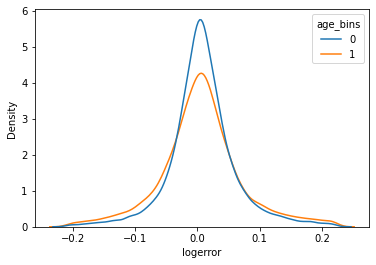

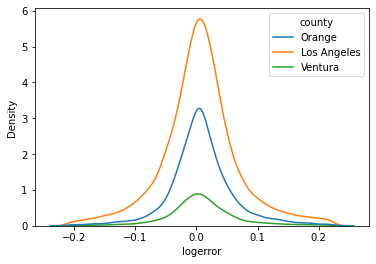

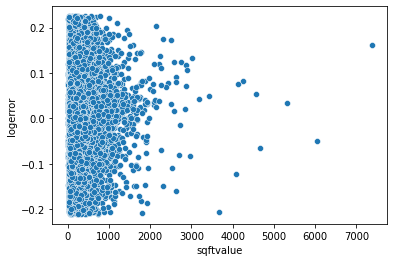

In [66]:
sns.kdeplot(data=X_train, hue='age_bins', x=y_train)
plt.show()
sns.kdeplot(data=X_train, hue='county', x=y_train)
plt.show()
sns.scatterplot(data=X_train, x='sqftvalue', y=y_train)
plt.show()

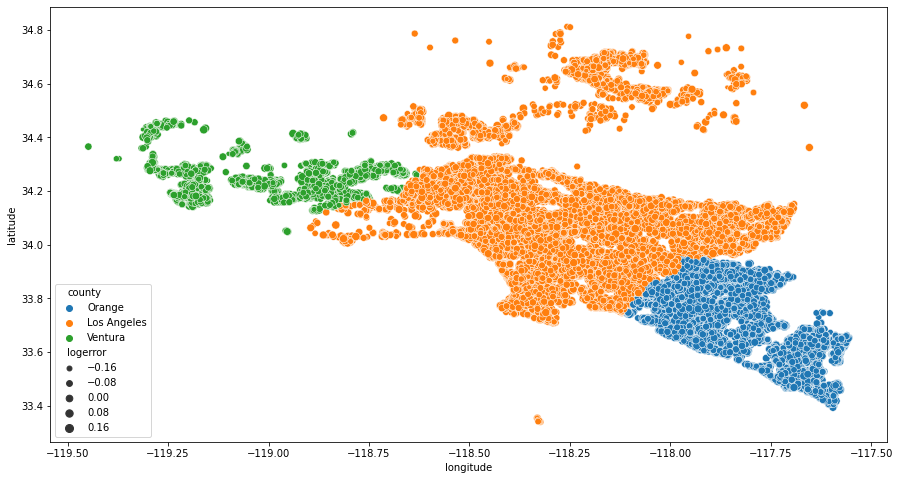

In [68]:
f,ax = plt.subplots(figsize=(15,8))
sns.scatterplot(data=X_train, x='longitude', y='latitude', hue='county', size=y_train, )

In [67]:
lac = y_train[X_train.county=="Los Angeles"]
oc = y_train[X_train.county=="Orange"]
vc = y_train[X_train.county=="Ventura"]
lac_oc = scs.mannwhitneyu(lac, oc)
lac_vc = scs.mannwhitneyu(lac, vc)
vc_oc = scs.mannwhitneyu(vc, oc)

print(f"Mean errors: LA {lac.mean()}, OC {oc.mean()}, VC {vc.mean()}")
print("p-values comparing means of logerrors:")
print(f"LAC, OC: {lac_oc[1]}")
print(f"LAC, VC: {lac_vc[1]}")
print(f"VC, OC: {vc_oc[1]}")

Mean errors: LA 0.006233369618302669, OC 0.008272331245042574, VC 0.008831789252695975
p-values comparing means of logerrors:
LAC, OC: 0.003364048989337885
LAC, VC: 0.0641339021957533
VC, OC: 0.4006410600633486


In [69]:
new = y_train[X_train.age_bins==0] #newer
old = y_train[X_train.age_bins==1]

new_old = scs.mannwhitneyu(new, old)

print("\np-values comparing means of logerrors:")
print(f"Newer, older: {new_old[1]}")


p-values comparing means of logerrors:
Newer, older: 1.878560499593177e-07


In [70]:
scs.pearsonr(X_train.sqftvalue, y_train)

(-0.004360373416328573, 0.34077814370241377)

In [71]:
X_train.drop(columns=['county'], inplace=True)

f_selector = make_pipeline(MinMaxScaler(), SelectKBest(f_regression, k=10))
f_selector.fit(X_train, y_train)
feature_mask = f_selector[1].get_support()
f_feature = X_train.iloc[:,feature_mask].columns.tolist()
f_feature

/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


['bathroomcnt',
 'bedroomcnt',
 'finishedsqft',
 'heatingorsystemtypeid',
 'structuretaxvalue',
 'taxvalue',
 'landtaxvalue',
 'taxamount',
 'livingarearatio',
 'age']

In [72]:
mean_error = y_train.mean()
zips = set(X_train.regionidzip)
alpha = .05
sig_zips = []
print(f"Mean logerror: {mean_error}\n")

for zip_ in zips:

  subset = y_train[X_train.regionidzip==zip_]
  mean_vec = np.zeros((1, len(subset))) + mean_error
  
  #Welch's T-test comparing zip code logerror mean to population mean
  p = scs.ttest_ind(subset, mean_vec[0], equal_var=False)[1]
  
  if p < alpha:
    sig_zips.append(zip_)
    print(f"RTN for {zip_} - mu, sigma, n: {round(subset.mean(),3), round(subset.std(),3), len(subset)}")

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Mean logerror: 0.007038104626256655

RTN for 96268.0 - mu, sigma, n: (0.026, 0.064, 129)
RTN for 96271.0 - mu, sigma, n: (-0.006, 0.069, 120)
RTN for 96280.0 - mu, sigma, n: (-0.026, 0.075, 71)
RTN for 96292.0 - mu, sigma, n: (-0.007, 0.075, 126)
RTN for 96294.0 - mu, sigma, n: (-0.012, 0.063, 137)
RTN for 96326.0 - mu, sigma, n: (-0.019, 0.068, 55)
RTN for 96336.0 - mu, sigma, n: (0.022, 0.056, 97)
RTN for 96349.0 - mu, sigma, n: (0.016, 0.065, 225)
RTN for 96368.0 - mu, sigma, n: (0.015, 0.058, 293)
RTN for 96371.0 - mu, sigma, n: (-0.016, 0.072, 49)
RTN for 96379.0 - mu, sigma, n: (0.019, 0.057, 189)
RTN for 96383.0 - mu, sigma, n: (0.015, 0.055, 247)
RTN for 96387.0 - mu, sigma, n: (0.019, 0.058, 189)
RTN for 96398.0 - mu, sigma, n: (0.014, 0.042, 146)
RTN for 96403.0 - mu, sigma, n: (0.017, 0.059, 143)
RTN for 96410.0 - mu, sigma, n: (-0.015, 0.076, 129)
RTN for 96437.0 - mu, sigma, n: (-0.003, 0.052, 131)
RTN for 96450.0 - mu, sigma, n: (-0.027, 0.077, 82)
RTN for 96464.0 - mu, s

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [76]:
f"The t-tests identified {len(sig_zips)} zips with mean errors significantly different than mean error of all {len(zips)} sips"

'The t-tests identified 89 zips with mean errors significantly different than mean error of all 385 sips'